### 取得資料方式

直接從 Bitcore dat 檔案取得 transaction 資料，程式碼在 https://github.com/CS-703059001-group4/blockchain-to-parquet 。

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
import matplotlib.ticker as ticker
from matplotlib import pyplot
from datetime import date
import seaborn as sns
import numpy as np
import pandas as pd
import time
import random
sns.set()

In [ ]:
spark = SparkSession.builder \
                    .master("local[4]") \
                    .config("spark.driver.memory", "4g") \
                    .getOrCreate()

sc = spark.sparkContext

In [ ]:
def date_converter(d):
    if isinstance(d, date):
        d = time.mktime(d.timetuple())
    return d

def vout_types(li):
    d = set([])
    for i in li:
        d.add(i["type"])
    return list(d)

def tx_date(s):
    return date.fromtimestamp(s)

def count_types(types):
    counter = {}
    for li in types:
        for i in li:
            counter[i] = counter.get(i, 0) + 1
    return counter

def add_random_value(val):
    return val + random.uniform(-0.1, 0.1)

In [ ]:
origin_df = spark.read.load("../data/*.parquet")
origin_df.columns

['hash',
 'lock_time',
 'size',
 'received_time',
 'total_input',
 'total_output',
 'block',
 'vin',
 'vout']

### 看時間、vout 類型

In [ ]:
df = origin_df.withColumn("vout_types", udf(vout_types, returnType=ArrayType(StringType()))("vout"))
df = df.withColumn("date", udf(tx_date, returnType=DateType())("received_time"))
df = df.groupBy("date").agg(
    collect_list("vout_types").alias("vout_types_nested"),
    count("*").alias("count"),
    sum("total_output").alias("total_output")
)
df = df.withColumn("types", udf(count_types, returnType=MapType(StringType(), IntegerType()))("vout_types_nested"))
df = df.drop("vout_types_nested")
df = df.cache()

In [ ]:
origin_data = df.select("date", "types").toPandas()
origin_data.head()

,date,types
0,2018-09-09,"{u'witness_v0_keyhash': 13282, u'witness_v0_sc..."
1,2018-10-05,"{u'witness_v0_keyhash': 31047, u'witness_v0_sc..."
2,2018-09-08,"{u'pubkeyhash': 23348, u'witness_v0_scripthash..."
3,2018-09-18,"{u'witness_v0_keyhash': 33455, u'witness_v0_sc..."
4,2018-09-24,"{u'witness_v0_keyhash': 28866, u'witness_v0_sc..."


In [ ]:
types = origin_data.types.map(lambda types: set([key for key in types])).values
types = reduce(lambda final, types: final.union(types), types, set())
types = list(types)
type_columns = np.array([origin_data.types.map(lambda types: types.get(typ, 0)) for typ in types])
type_columns = type_columns.transpose()
data = pd.DataFrame(type_columns, origin_data.date, columns=types)
data.head()

,witness_v0_keyhash,witness_v0_scripthash,nulldata,scripthash,pubkeyhash,nonstandard,multisig,pubkey
date,,,,,,,,
2018-09-09,13282,470,7212,59246,83032,21,3,138
2018-10-05,31047,810,16822,129892,167748,29,3,180
2018-09-08,4469,117,1122,15931,23348,3,0,38
2018-09-18,33455,1328,15364,144285,197735,39,7,255
2018-09-24,28866,987,21275,120568,176219,34,6,208


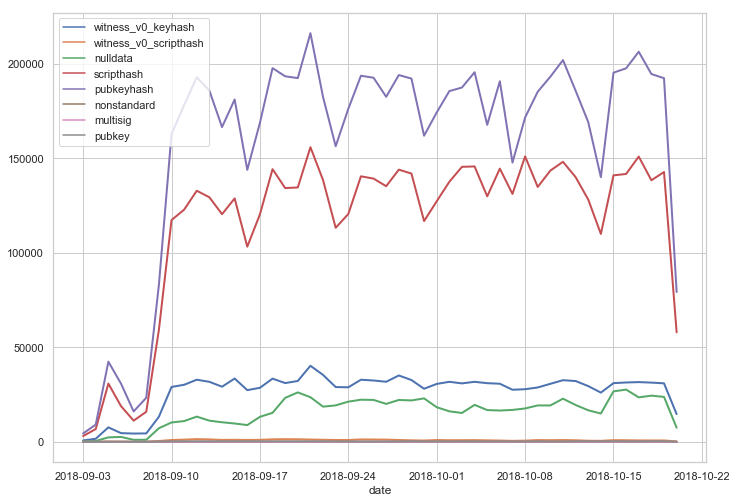

In [ ]:
sns.set(style="whitegrid")
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.lineplot(ax=ax, data=data, linewidth=2, dashes=False)

Bitcore 在下載 blockchain 資料的時候並不會照時間先後順序下載，儲存到 dat 檔案時也不會按照時間順序儲存資料，因此造成上圖中前幾天資料較少的情況，這是直接從 dat 檔案取得資料的一個問題。

### vout 類型、金額

In [ ]:
combine = udf(
    lambda x, y: list(zip(x, y)),
    ArrayType(StructType([
        StructField("value", DoubleType()),
        StructField("type", StringType())
    ]))
)

typeIndexer = StringIndexer(inputCol="type", outputCol="type_index")
df2 = origin_df.select("vout.value", "vout.type")\
    .withColumn("tmp", combine("value", "type"))\
    .withColumn("tmp", explode("tmp"))\
    .select(col("tmp.value"), col("tmp.type"))\
    .cache()
df2 = typeIndexer.fit(df2).transform(df2)

In [ ]:
df3 = df2.groupBy("type")\
    .agg(
        mean("value").alias("mean"),
        count("*").alias("count"),
    )\
    .select("type", "mean", "count")\

In [ ]:
df3.toPandas()

,type,mean,count
0,pubkeyhash,1.356472e+00,13466779
1,nulldata,1.000460e-09,766697
2,scripthash,1.678874e+00,9572193
3,pubkey,1.637662e-04,77611
4,nonstandard,0.000000e+00,1367
5,witness_v0_scripthash,4.370073e+00,45096
6,multisig,7.728663e-05,424
7,witness_v0_keyhash,1.818470e+00,1328646


In [ ]:
df4 = df2.withColumn("type_index", udf(add_random_value)("type_index"))
df4 = df4.cache()

In [ ]:
data = df2.select("type_index", "value").sample(False, 0.3).toPandas()

In [ ]:
data.head()

,type_index,value
0,1.0,0.836449
1,1.0,0.734390
2,0.0,4.625172
3,0.0,4.519909
4,0.0,2.789178


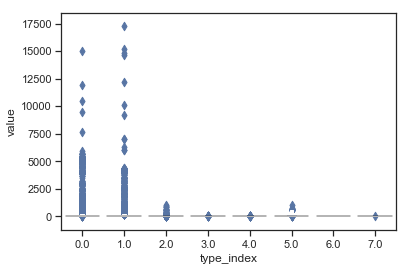

In [ ]:
sns.boxenplot(x="type_index", y="value", color="b", scale="linear", data=data)

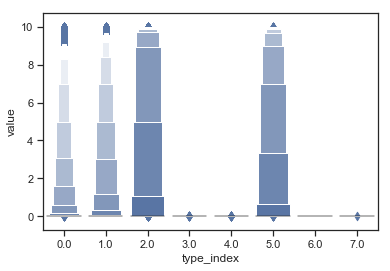

In [ ]:
sns.boxenplot(x="type_index", y="value", color="b", scale="linear", data=data.query("value < 10"))